# Why are some athletes more popular than others?
The 2018 Cleveland Cavs made the NBA finals while generating some of the hottest memes of 2018 ("We got an \[expletive\] squad now," "He boomed me."). Following the Cavs on Reddit, I noticed something odd. Turkish rookie Cedi Osman was a particular fan favourite. Cedi played limited minutes with energy, and everyone joked that Cedi was the "GOAT" (Greatest Of All Time) carrying Lebron. In contrast, Tristan Thompson, a hero of the 2016 season, had an off year, and was the center of a meme for being traded, "Shump, TT, and the Nets pick." For the Cavs at least, it seemed commenters gave the white players an easier time. And being a data scientist, I thought, "I could measure that!"

In this project, I am going to show how I used sentiment and econometric models to understand what makes NBA and NFL players popular. I split this project into three parts. In this notebook, Part 1, I will focus on scraping player comments from Reddit, and how to download covariate data for players (e.g. performance and demographics). In [part 2](https://github.com/map222/trailofpapers/blob/sentiment_sports/sentiment_sports/paper/calculating_player_sentiment.ipynb), I will isolate comments about single players using named entity recognition, and show how to calculate sentiment towards players. In part 3, I will use econometric regression models to investigate what drives sentiment towards players.

## How do we understand public opinion towards athletes?
In the past, companies have quantified public opinion towards athletes using surveys like Q-score. While surveys provide precise quantitative answers, they are inherently biased, since only a small fraction of people respond to surveys. Furthermore, people's stated opinions may be different from their honest opinions, due to self-censoring, or lack of self-knowledge.

Instead, thanks to social media and natural language processing techniques, we can analyze how people naturally talk about players. This allows us to get opinions from a wider group of people (although it still may overrepresent loud people), and to infer the public's real opinion. Social media also allows you to measure community effects as well, as people upvote and downvote opinions. The formation of opinion in these online communities is often a bellwether for how the general public will feel later.

For the remainder of this notebook I am going to cover how I scraped Reddit for comments.
## Part 1: Scraping data
### Scraping comment data from Reddit
My primary source of player comments were the active [NBA](https://www.reddit.com/r/nba) and [NFL](https://www.reddit.com/r/nfl) subreddits. I also tried scraping Twitter; while the Twitter API works well for live data, I found getting historical data difficult.

There are a few different options for scraping data from Reddit. First, there is the [official Reddit API](https://www.reddit.com/dev/api/), which allows one to scrape reddit, post comments, and vote. I started this project using the official API, but stopped after an update broke my code (you can see this original code in the [appendix of this notebook](https://nbviewer.jupyter.org/github/map222/trailofpapers/blob/sentiment_sports/sentiment_sports/paper/calculating_player_sentiment.ipynb#appendix).

For the majority of this project I used the [pushshift](pushshift.io) API. Pushshift is a third party social media database that scrapes reddit, and makes it available to others. I found this API more stable and easier to use since it did not require authentication.

I originally did the reddit scraping in a Jupyter notebook before realizing that I was repeating myself. Taking a note from [Joel Grus](https://www.youtube.com/watch?v=7jiPeIFXb6U), I function-ified my notebook into a module [`scrape_reddit_comments`](https://nbviewer.jupyter.org/github/map222/trailofpapers/blob/sentiment_sports/sentiment_sports/paper/scrape_reddit_comments.py) to make it easier to use. In this section of the notebook I'm going to walk through the main parts of the function `get_month_pushshift` from that module, which scrapes submissions (original posts) and comments (replies) for one month of a subreddit.
#### Imports

In [1]:
import sys
sys.path.append("..")
data_path = 'd:/data/sentiment_sports/'
import scrape_reddit_comments as src
from scrape_reddit_comments import parse_submission_pushshift

In [2]:
import pandas as pd
import time
import json
import requests
from datetime import datetime
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', 50)

### Scraping code
#### Initialize variables
For this example, I want to scrape a few days of data from r/NBA for January 2018. Let's start by initializing variables for dates and times. The scraper works by stepping hour by hour through the month, so we can use datetime methods to calculate the start and end time of the month.

In [3]:
year, month, day = 2018, 1, 3
start_after = datetime.now() - datetime(year,month,1)
end_before = datetime.now() - datetime(year,month,day)
start_hour = start_after.total_seconds()  // 3600
end_hour = end_before.total_seconds()  // 3600 - 1

#### Setting up the API query
Pushshift uses a RESTful API, which means that it uses vanilla HTTP to serve data. For example, if you [click this link](https://api.pushshift.io/reddit/search/submission/?subreddit=nba&size=10), you should see a JSON object of 10 recent posts to /r/nba. Rather than using a browser and typing in URLs to get data, we can use the `requests` module to modify and process the URLs for us.

To use `requests`, we need two pieces of information: the URL we are going to query; and parameters for the query like which subreddit we are interested in. In this example I am using the URL for original posts ("submissions"); and I set the parameter for the NBA subreddit.

In [5]:
url_params = {'subreddit': 'nba',
              'size':500}
submission_url = 'https://api.pushshift.io/reddit/search/submission/'

#### Running the query for a month
Now that we have our basic query set up, we can start to get some data. Since the query is limited to 500 posts, to get get a whole month of data, we need to repeat the query for every day of the month, or even multiple times in a day (here we are only doing 6 days, as defined above). The `for` loop below does just that, modifying the time parameter with six hour increments. I also include a `time.sleep` to prevent the API from getting overloaded.

In [6]:
# initialize list of submissions
month_submissions = []

# run data request for "submissions" (original post)
print('Downloading submissions for {}-{}'.format(year, month))
hour_step = 6
for hour in range(start_hour, end_hour, -hour_step):
    url_params.update({'before': str(hour)+'h', 'after': str(hour+hour_step) + 'h'})
    pushshift_response = json.loads(requests.get(submission_url, params=url_params).text)
    month_submissions.extend(pushshift_response['data'])
    time.sleep(0.5)

#### Example JSON response

In [7]:
month_submissions[1]

{'author': 'manuginobilistan',
 'author_flair_css_class': None,
 'author_flair_text': None,
 'brand_safe': True,
 'can_mod_post': False,
 'contest_mode': False,
 'created_utc': 1514775573,
 'domain': 'self.nba',
 'full_link': 'https://www.reddit.com/r/nba/comments/7ncuar/get_manu_ginobili_to_be_a_west_captain/',
 'id': '7ncuar',
 'is_crosspostable': False,
 'is_reddit_media_domain': False,
 'is_self': True,
 'is_video': False,
 'locked': False,
 'num_comments': 0,
 'num_crossposts': 0,
 'over_18': False,
 'parent_whitelist_status': 'all_ads',
 'permalink': '/r/nba/comments/7ncuar/get_manu_ginobili_to_be_a_west_captain/',
 'pinned': False,
 'retrieved_on': 1514848605,
 'score': 1,
 'selftext': '[removed]',
 'spoiler': False,
 'stickied': False,
 'subreddit': 'nba',
 'subreddit_id': 't5_2qo4s',
 'subreddit_type': 'public',
 'thumbnail': 'default',
 'title': 'GET MANU GINOBILI TO BE A WEST CAPTAIN',
 'url': 'https://www.reddit.com/r/nba/comments/7ncuar/get_manu_ginobili_to_be_a_west_capta

#### Parsing the submissions
Pushshift returns a JSON object for each query, which includes fields for the submission text, user, and more. To extract these, I created a helper function `parse_submission_pushshift`, which returns the values as a tuple. This is most useful for handling missing fields in the JSON gracefully

In [33]:
parse_submission_pushshift(month_submissions[1])

('Lebron and Kevin Durant enter a gym, who leaves first?. Both are known to have insane workouts and work ethic, both are trying to be the best in the world, so who leaves the gym first?',
 1514762814,
 'DaLaTy',
 'Warriors',
 0,
 '7nbrpc',
 '7nbrpc',
 '7nbrpc')

Using this parser function, I create a dataframe for the month.

In [37]:
ops = [ parse_submission_pushshift(submission) for submission in month_submissions]
data_col = ['text', 'timestamp', 'user', 'flair', 'score', 'id', 'link_id', 'parent_id']
submission_df =(pd.DataFrame(ops, columns=data_col)
                  .assign(source = lambda x: 'submission') )
print('Made dataframe of shape {}'.format(submission_df.shape) )

Made dataframe of shape (22953, 9)


The processed dataframe contains the following data:
* text: the text from the submissions or comment. These can include emojis
* timestamp: unix timestamp for the post
* user: the reddit username of the post author
* flair: subreddits allow users to express a "flair," for example "[CLE]"
* score: the net karma for the submissions or post
* id: the unique ID for the post or submssion
* link_id: this is the ID for the original post
* parent_id: for comments, this is the id of the "parent" post in the thread; for submissions, this is the same as the link_id
* source: whether the text is from a submission (original post) or comment (reply)

In [38]:
submission_df.head(2)

,text,timestamp,user,flair,score,id,link_id,parent_id,source
0,"GAME THREAD: Memphis Grizzlies (11-25) @ Sacramento Kings (12-23) - (December 31, 2017). ##Gener...",1514762996,eatmorebread,Kings,6,7nbs8v,7nbs8v,7nbs8v,submission
1,Kyrie on what he'd do if he wasn't a NBA player. [deleted],1514763030,[deleted],None,1,7nbsdc,7nbsdc,7nbsdc,submission


The function `get_month_pushshift` in `scrape_reddit_comments` repeats this process for the comments, using a smaller time step (one hour), and a different helper function (`parse_comment_pushshift`). For details, I would suggest looking at the [module](https://github.com/map222/trailofpapers/blob/sentiment_sports/sentiment_sports/scrape_reddit_comments.py).
### Scraping data using the module
Once you understand the basic code for scraping, you can do things more easily using the `get_month_pushshift` function. The function takes four parameters:
* year: integer of year you want to scrape (I scraped back to ~2013)
* month: integer of month you want to scrape
* last_day: integer of last day of month; I manually changed this for every month; you should probably use a lookup table!
* league: str name of subreddit you want to scrape. I used `nfl` and `nba`.

In [ ]:
%%time
subreddit = 'nba'
year = 2015
month = 12
last_day = 2
month_df, submissions, comments = src.get_month_pushshift(year,month, last_day, subreddit)

Running the above code usually takes 20-25 minutes for a full month (the example above only does 2 days). Pushshift typically yields ~300k comments / month for /r/NBA during the season.

In [26]:
month_df.sample(2, random_state=24607)

,text,timestamp,user,flair,score,id,link_id,parent_id,source
99440,MARK JACKSON FOR GM! #thenightmare,1.452452e+09,Asprobouboulis,Spurs,8.0,cyt3rc8,t3_40cist,t3_40cist,comment
91900,I don't think that anybody is going to try to argue that Lebron is a better scorer than MJ. Care...,1.452380e+09,BIGJ0N,Charlotte Hornets,5.0,cys8p4l,t3_40728l,t1_cys0qgl,comment


#### Downloading NFL comments
While I have focused here on downloading NBA comments, I repeated this task for the NFL as well. This was as simple as changing the subreddit to "nfl" and changing the dates to the appropriate months.
### Save / load
Finally, after downloading the comments, I save them to disk. Note the use of f-strings, which allow you to use the league, year, and month parameters to name your file. (Something weird is going on where this throws a `UnicodeDecodeError` when writing to a gzipped file.)

In [ ]:
month_df.to_csv(data_path + f'{league}_reddit_comments/{year}{month:02}-comments_submissions.tsv',
                sep = '\t', encoding = 'utf-8',index = False)

## Obtaining covariate data
To understand what drives player sentiment, I also needed to get demographic and performance data. This scraping was less interesting than scraping the reddit comments, so here is a sample of the covariate data for two players (details of the covariate scraping are in the appendix):

In [3]:
example_df = pd.read_csv('../modeling_data/nba_model_data.tsv',sep='\t')
example_df.sample(2, random_state=2016)\
           [['Player', 'season', 'Race', 'Ht', 'Wt', 'G', 'PER','PPG', 'TRBP', 'FTr', 'salary', 'experience', 'Wins', 'white_black_diff']]

,Player,season,Race,Ht,Wt,G,PER,PPG,TRBP,FTr,salary,experience,Wins,white_black_diff
1101,iman shumpert,2016,B,77.0,220.0,76.0,9.0,7.5,6.2,0.184,9662922.0,5.0,51.0,54.0
1183,james ennis,2017,B,79.0,210.0,72.0,11.6,7.1,8.0,0.302,3028410.0,3.0,22.0,0.6


Definition of some covariates in the sample:
* Player: lowercase name of the player
* Season: year the performance and age data comes from
* Race: (W)hite, (B)lack, (A)sian
* Ht / Wt: Height in inches and weight in pounds
* G: Games played that season
* PER: Player efficiency rating, an advanced stat characterizing overall offense
* PPG: points per game
* TRBP: total rebound percentage
* FTr: Free throws attempted per shot
* salary: dollar value of salary
* experience: # of years in the league (min 1)
* Wins: Team wins that year for team the player was on the most
* white_black_diff: For a given city, the difference between the percent population that is white - percent of population that is black (white% - black%).

There are a whole host of other performance columns not shown. The [full dataset is on github](https://github.com/map222/trailofpapers/blob/sentiment_sports/sentiment_sports/modeling_data/).

## Conclusion
In part I of the project, I showed you how to scrape comments from reddit for the NBA; and how to use a function to make that process easier. In part II, I will show you how to analyze these comments to calculate sentiment towards player.

## Appendix<a id='appendix'></a> 
### Details of covariate scraping
To repeatably scrape covariate data, I built a [set of functions](https://github.com/map222/trailofpapers/blob/sentiment_sports/sentiment_sports/scrape_player_data.py) that queried [basketball-reference.com](https://basketball-reference.com), [pro-football-reference.com](https://pro-football-reference.com), [footballoutsiders.com](https://footballoutsiders.com/), and Wikipedia. In this section I won't go over the specific code for each dataset, but just show how to query the data.
#### Import module

In [57]:
import scrape_player_data as spd

### NBA
#### Scrape player performance
I wrote a helper function, `get_year_performance`, to scrape NBA player info from `basketball-reference.com`. I use this function for each year, then simply concatenate the results into a single dataframe.

In [ ]:
performance2018_df = spd.get_year_performance_nba(2018).assign(season = lambda row: row['year'] -1)
performance2017_df = spd.get_year_performance_nba(2017).assign(season = lambda row: row['year'] -1)
performance2016_df = spd.get_year_performance_nba(2016).assign(season = lambda row: row['year'] -1)
performance2015_df = spd.get_year_performance_nba(2015).assign(season = lambda row: row['year'] -1)
performance2014_df = spd.get_year_performance_nba(2014).assign(season = lambda row: row['year'] -1)
performance2013_df = spd.get_year_performance_nba(2013).assign(season = lambda row: row['year'] -1)
performance_df = pd.concat([performance2013_df, performance2014_df, performance2015_df, performance2016_df, performance2017_df, performance2018_df])

#### Remember to save your data

In [31]:
performance_df.to_csv('nba_performance.tsv', sep='\t', index = False)

#### Player demographics
It was difficult to find a list of NBA player ethnicities, so I just googled the pictures of a few hundred players. I downloaded height and weight information from basketball-reference.com.

In [21]:
demo_df = pd.read_csv(data_path + 'covariates/nba_players2013.tsv', sep ='\t', encoding = 'utf-8')
demo_df['Player'] = demo_df['Player'].str.lower()

While parsing the heights, it sometimes gets saved as a date. Convert these dates to inches.

In [22]:
demo_df['Ht'] = demo_df['Ht'].str.split('-')
height_dict = {'Jun':72, 'Jul':84, 'May':60}
height_dict.update({str(x):x for x in range(13)})
height_dict.update({'00':0})
demo_df['Ht'] = demo_df['Ht'].apply(lambda row: height_dict[row[0]]*12 + height_dict[row[1]])

#### Team info
I downloaded team performance data from basketball-reference.com using `pandas.read_html`.

In [ ]:
for year in range(2014, 2019):
    team_year_df = pd.concat(pd.read_html(f'https://www.basketball-reference.com/leagues/NBA_{year}.html')[:2]).assign(year = year)
    team_year_df.to_csv(data_path + f'covariates/nba_teams{year}.tsv', sep='\t', index=False)

In [13]:
# then hand edit the 3-letter team names
team_df = pd.concat([pd.read_csv(data_path + 'covariates/nba_teams2014.tsv', sep='\t'),
                     pd.read_csv(data_path + 'covariates/nba_teams2015.tsv', sep='\t'),
                     pd.read_csv(data_path + 'covariates/nba_teams2016.tsv', sep='\t'),
                     pd.read_csv(data_path + 'covariates/nba_teams2017.tsv', sep='\t'),
                     pd.read_csv(data_path + 'covariates/nba_teams2018.tsv', sep='\t')])

#### Salary
I downloaded salary information from [HoopsHype](https://hoopshype.com/salaries/) using `pandas.read_html`

In [15]:
def get_nba_salary_year(season):
    return (pd.read_html(f'https://hoopshype.com/salaries/players/{season}-{season+1}/')[0]
              .rename(columns = {str(season) + '/' +  str(season+1)[2:]: 'salary'})
              .assign(season = season))
salary_df = pd.concat([get_nba_salary_year(season) for season in range(2010, 2019)])[['Player', 'salary', 'season']]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """


The salary format was a little wonky, so I used `locale` to fix it

In [16]:
salary_df['Player'] = salary_df['Player'].str.lower()
import locale
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 
salary_df['salary'] = salary_df['salary'].str[1:].apply(locale.atoi)

#### Salary standardization
For regression, I also tried to standardize the salaries.  After taking the 4th root, things looked decent.

In [17]:
salary_df['standard_salary'] = np.power(salary_df['salary'], 1/4)

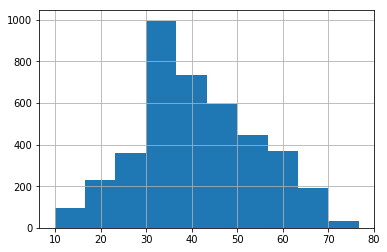

In [18]:
np.power(salary_df['salary'], 1/4).hist();

### City information
When thinking about race, we considered whether the demographics of the city influence player popularity. I downloaded census and polling data for both NBA and NFL cities (I forgot the sites). I then spent some time making sure all the join keys were correct.
#### City demographics

In [19]:
# city demographics
city_df = pd.read_csv('d:/data/sentiment_sports/covariates/sports_metro_demographics.csv').drop(columns = ['census_Id', 'census_Id2', 'Geography'])

#### City voting during 2016 election

In [33]:
vote_df = pd.read_csv('d:/data/sentiment_sports/covariates/msa_votes.tsv', sep='\t')[['per_point_diff', 'Tm']].rename(columns={'per_point_diff':'clinton_vote_lead'})

### Combine info
After getting all of the data for various covariates, I combined them into a single dataframe that has performance, demographics, and city information.

In [34]:
covariates_df = (demo_df.merge(performance_df, on = 'Player')
                      .merge(team_df, on=['Tm', 'year'])
                      .merge(city_df, on='Tm')
                      .merge(vote_df, on='Tm') )
covariates_df['Player'] = covariates_df['Player'].str.replace('.', '')
covariates_df = covariates_df.merge(salary_df, on=['Player', 'season'], how='left')
covariates_df['experience'] = covariates_df['year'] - covariates_df['From']
covariates_df.head(2)

,Player,Race,From,To,Pos_x,Ht,Wt,Birth Date,Colleges,Rk,...,year,season,Wins,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,salary,standard_salary,experience
0,alex abrines,W,2017,2018,G-F,78,190,"August 1, 1993",NaN,1,...,2017,2016,47,1337075,74.1,10.2,0.1051,5994764.0,49.481519,0
1,steven adams,W,2014,2018,C,84,255,"July 20, 1993",University of Pittsburgh,3,...,2017,2016,47,1337075,74.1,10.2,0.1051,3140517.0,42.096917,3


### Coach data
In addition to getting player data, I wanted to get coach data. For coaches, we have fewer features (just wins). Here, I wrote a simple function to scrape basketball-reference.com, `scrape_nba_coaches`. 

In [ ]:
nba_coach_df = spd.scrape_nba_coaches()
nba_coach_df.to_csv('d:/data/sentiment_sports/covariates/nba_coach_performance.tsv', sep='\t', index=False)

## NFL data
In addition to understanding what drives NBA player sentiment, I wanted to look at other sports, specifically the NFL. Rather than step through each individual function to scrape the data, I would instead refer you to the `scrape_player_data` module.

### Using PRAW
Before using pushshift, I used the official reddit API via the [praw](https://praw.readthedocs.io/en/latest/) module. Unfortunately, an API update broke this code, so this is mostly here for posterity. If you figure out how to run this, let me know!

In [1]:
import time
from datetime import datetime
import json
import pandas as pd
import praw # for direct reddit pull

In [2]:
client_id = 'nope'
secret = 'nope'
user_agent = 'r/nba race sentiment 0.1 by /u/Umiy'

In [3]:
r = praw.Reddit(user_agent=user_agent, client_id=client_id, client_secret=secret)
r_nba = r.subreddit('nba')

In [138]:
def parse_submission( submission):
    text = submission.title + '. ' + submission.selftext
    creation_date = submission.created
    author = submission.author #.name for PRAW
    flair = submission.author_flair_text
    score = submission.score
    return (text, creation_date, author, flair, score)

In [140]:
def parse_comment( comment):
    if hasattr(comment, 'body') and comment.author != None:
        text = comment.body
        creation_date = comment.created
        author = comment.author
        flair = comment.author_flair_text
        score = comment.score
        return (text, creation_date, author, flair, score)
    return ('', 1, '', '', 0)

In [6]:
def get_month(year, month, month_length):
    ''' Get comments and submissions for one month. takes ~ 1h 15 minutes.
    '''
    data_col = ['text', 'timestamp', 'user', 'flair']
    print('Downloading submssions for {}-{}'.format(year, month))
    month_submissions = [list(r_nba.submissions(datetime(year,month,day).timestamp(), datetime(year,month,day+1).timestamp() )) for day in range(1,month_length)]
    month_submissions = [x for day_submissions in month_submissions for x in day_submissions]
    
    print('Downloaded {} submissions'.format(len(month_submissions)))
    ops = [ parse_submission(submission) for submission in month_submissions]
    submission_df =(pd.DataFrame(ops, columns=data_col)
                      .assign(source = lambda x: 'submission') )
    print('Made dataframe of shape {}'.format(submission_df.shape) )
    
    print('Downloading comments (this could take an hour)')
    comments_list = [submission.comments.list() for submission in month_submissions if hasattr(submission, 'comments')]
    comments = [ parse_comment(comment) for comments in  comments_list for comment in comments]
    print('Downloaded {} comments'.format(len(comments) ) )
    comment_df = (pd.DataFrame(comments, columns=data_col)
                    .assign(source = lambda x: 'comment') )
    return pd.concat([submission_df, comment_df]), ops, comments

In [ ]:
%%time
# this no longer works 
month_df, submissions, comments = get_month(2017, 11, 30)